## Uniform

Processing step 0
Processing step 20
Processing step 40
Processing step 60
Processing step 80


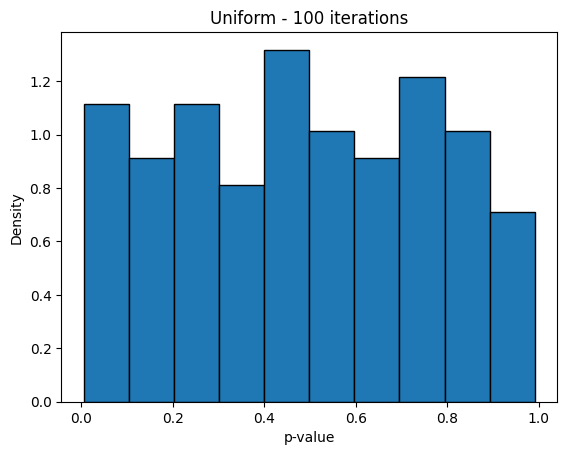

In [3]:
import numpy as np
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt

from CoRT_builder import CoRT
import utils
import parametric_optim
import oc
from mpmath import mp

import importlib

importlib.reload(utils)
importlib.reload(parametric_optim)

n_target = 30
n_source = 10
p = 10
K = 5
Ka = 3
h = 30
lamda = 0.1
alpha = 0.05
s_vector = [0] * 2
T = 3
s = len(s_vector)
CoRT_model = CoRT(alpha=lamda)
p_values = []
iteration = 100

for step in range(iteration):
    if step % 20 == 0:
        print(f"Processing step {step}")

    target_data, source_data = CoRT_model.gen_data(n_target, n_source, p, K, Ka, h, s_vector, s, "AR")
    similar_source_index = CoRT_model.find_similar_source(n_target, K, target_data, source_data, T=T, verbose=False)
    X_combined, y_combined = CoRT_model.prepare_CoRT_data(similar_source_index, source_data, target_data)

    model = Lasso(alpha=lamda, fit_intercept=False, tol=1e-10, max_iter=10000000)
    model.fit(X_combined, y_combined.ravel())
    beta_hat_target = model.coef_[-p:]

    active_indices = np.array([i for i, b in enumerate(beta_hat_target) if b != 0])
    initial_active_indices = active_indices

    if len(active_indices) == 0:
        print(f"Iteration {iter}: Lasso selected no features. Skipping.")
        continue

    j = np.random.choice(len(active_indices))

    selected_feature_index = active_indices[j]

    X_target = target_data["X"]
    y_target = target_data["y"]
    X_active, X_inactive = utils.get_active_X(beta_hat_target, X_target)

    etaj, etajTy = utils.construct_test_statistic(y_target, j, X_active)

    Sigma = np.eye(n_target)
    b_global = Sigma @ etaj @ np.linalg.pinv(etaj.T @ Sigma @ etaj)
    a_global = (Sigma - b_global @ etaj.T) @ y_target

    folds = utils.split_target(T, X_target, y_target, n_target)

    tn_sigma = mp.mpf((np.sqrt(etaj.T @ Sigma @ etaj)).item())
    z_k = -20 
    z_max = 20 

    Z_train_list = parametric_optim.get_Z_train(z_k, folds, source_data, a_global, b_global, lamda, K, T)
    Z_val_list, similar_source_index, cnt_vote, is_similar = parametric_optim.get_Z_val(z_k, folds, T, K, a_global, b_global, lamda, source_data)

    target_data_current = {"X": X_target, "y": a_global + z_k * b_global}
    X_combined_new, y_combined_new = CoRT_model.prepare_CoRT_data(similar_source_index, source_data, target_data_current)
    L_CoRT, R_CoRT, Az = parametric_optim.get_Z_CoRT(X_combined_new, similar_source_index, lamda, a_global, b_global, source_data, z_k)

    z_list = [z_k]
    Az_list = []
    matched_active_set = None

    stopper = "empty"
    while z_k < z_max:
        current_num_sources = len(similar_source_index)
        offset = p * current_num_sources
        Az_target_current = np.array([idx - offset for idx in Az if idx >= offset])
        Az_list.append(Az_target_current)

        mn = z_max
        stopper = "MAX"

        for val in Z_train_list:
            if mn > val[4]:
                mn = val[4]
                stopper = "TRAIN"

        for val in Z_val_list:
            if mn > val[3]:
                mn = val[3]
                stopper = "VAL"

        if mn > R_CoRT:
            mn = R_CoRT
            stopper = "CORT"

        R_final = mn

        z_k = max(R_final, z_k) + 1e-5

        if (z_k >= z_max):
            z_list.append(z_max)
            break
        else:
            z_list.append(z_k)

        update_train_needed = False
        update_val_needed = False
        update_cort_needed = False
        
        if stopper == "TRAIN":
            update_train_needed = True
            update_val_needed = True   

        elif stopper == "VAL":
            update_val_needed = True
            
        elif stopper == "CORT":
            update_cort_needed = True

        if update_train_needed:
            for val in Z_train_list:
                if val[4] <= z_k + 1e-9:
                    l, r = parametric_optim.update_Z_train(val, z_k, folds, source_data, a_global, b_global, lamda, K, T)
                    val[3] = l
                    val[4] = r

        if update_val_needed:
            for val in Z_val_list:
                l, r, similar_source_index, cnt_vote, is_similar, oke = parametric_optim.update_Z_val(val, z_k, folds, T, a_global, b_global, lamda, source_data, similar_source_index, cnt_vote, is_similar)
                val[2] = l
                val[3] = r
                if oke == True:
                    update_cort_needed = True

        if update_cort_needed:
            target_data_current = {"X": X_target, "y": a_global + z_k * b_global}
            X_combined_new, y_combined_new = CoRT_model.prepare_CoRT_data(similar_source_index, source_data, target_data_current)
            L_CoRT, R_CoRT, Az = parametric_optim.get_Z_CoRT(X_combined_new, similar_source_index, lamda, a_global, b_global, source_data, z_k)

    z_interval = []
    for i in range(len(Az_list)):
        if np.array_equal(active_indices, Az_list[i]):
                z_interval.append([z_list[i], z_list[i+1] - 1e-10]) 

    new_z_interval = []
    for interval in z_interval:
        if len(new_z_interval) == 0:
            new_z_interval.append(interval)

        else:
            dif = abs(interval[0] - new_z_interval[-1][1])
            if dif < 0.001:
                new_z_interval[-1][1] = interval[1]
            else:
                new_z_interval.append(interval)
    optim_z_interval = new_z_interval

    is_z_obs_in_intervals = False
    for i, interval in enumerate(optim_z_interval):
        if interval[0] <= etajTy <= interval[1]:
            is_z_obs_in_intervals = True
            break

    if is_z_obs_in_intervals == False:
        print(f" WARNING: z_obs is not in the intervals:\nz_obs: {etajTy:.5f}\nIntervals:{optim_z_interval}")

    optim_p_value = utils.pivot(active_indices, Az_list, z_list, etaj, etajTy, 0, Sigma)
    p_values.append(optim_p_value)

    if optim_p_value == 0:
        print(" WARNING: p-value is 0")

    if optim_p_value is None:
        print(" WARNING: p-value is None")

plt.hist(p_values, bins=10, edgecolor='black', density=True)
plt.title(f"Uniform - {iteration} iterations")
plt.xlabel("p-value")
plt.ylabel("Density")
plt.show()

## FPR and TPR

In [7]:
import numpy as np
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt

from CoRT_builder import CoRT
import utils
import parametric_optim
import oc
from mpmath import mp

import importlib

importlib.reload(utils)
importlib.reload(parametric_optim)

n_target = 30
n_source = 10
p = 15
K = 5
Ka = 3
h = 30
lamda = 0.1
alpha = 0.05
s_vector = [1] * 4
T = 3
s = len(s_vector)
CoRT_model = CoRT(alpha=lamda)
p_values = []
iteration = 200
para_results_storage = []

for step in range(iteration):
    if step % 20 == 0:
        print(f"Processing iteration {step}")
    
    target_data, source_data = CoRT_model.gen_data(n_target, n_source, p, K, Ka, h, s_vector, s, "AR")
    similar_source_index = CoRT_model.find_similar_source(n_target, K, target_data, source_data, T=T, verbose=False)
    X_combined, y_combined = CoRT_model.prepare_CoRT_data(similar_source_index, source_data, target_data)

    model = Lasso(alpha=lamda, fit_intercept=False, tol=1e-10, max_iter=10000000)
    model.fit(X_combined, y_combined.ravel())
    beta_hat_target = model.coef_[-p:]

    active_indices = np.array([i for i, b in enumerate(beta_hat_target) if b != 0])
    initial_active_indices = active_indices

    if len(active_indices) == 0:
        print(f"Iteration {iter}: Lasso selected no features. Skipping.")
        continue

    j = np.random.choice(len(active_indices))
    selected_feature_index = active_indices[j]

    X_target = target_data["X"]
    y_target = target_data["y"]
    X_active, X_inactive = utils.get_active_X(beta_hat_target, X_target)

    etaj, etajTy = utils.construct_test_statistic(y_target, j, X_active)

    Sigma = np.eye(n_target)
    b_global = Sigma @ etaj @ np.linalg.pinv(etaj.T @ Sigma @ etaj)
    a_global = (Sigma - b_global @ etaj.T) @ y_target

    folds = utils.split_target(T, X_target, y_target, n_target)

    tn_sigma = mp.mpf((np.sqrt(etaj.T @ Sigma @ etaj)).item())
    z_k = -20 
    z_max = 20 

    Z_train_list = parametric_optim.get_Z_train(z_k, folds, source_data, a_global, b_global, lamda, K, T)
    Z_val_list, similar_source_index, cnt_vote, is_similar = parametric_optim.get_Z_val(z_k, folds, T, K, a_global, b_global, lamda, source_data)

    target_data_current = {"X": X_target, "y": a_global + z_k * b_global}
    X_combined_new, y_combined_new = CoRT_model.prepare_CoRT_data(similar_source_index, source_data, target_data_current)
    L_CoRT, R_CoRT, Az = parametric_optim.get_Z_CoRT(X_combined_new, similar_source_index, lamda, a_global, b_global, source_data, z_k)

    z_list = [z_k]
    Az_list = []
    matched_active_set = None

    stopper = "empty"
    while z_k < z_max:
        current_num_sources = len(similar_source_index)
        offset = p * current_num_sources
        Az_target_current = np.array([idx - offset for idx in Az if idx >= offset])
        Az_list.append(Az_target_current)

        mn = z_max
        stopper = "MAX"

        for val in Z_train_list:
            if mn > val[4]:
                mn = val[4]
                stopper = "TRAIN"

        for val in Z_val_list:
            if mn > val[3]:
                mn = val[3]
                stopper = "VAL"

        if mn > R_CoRT:
            mn = R_CoRT
            stopper = "CORT"

        R_final = mn

        z_k = max(R_final, z_k) + 1e-5

        if (z_k >= z_max):
            z_list.append(z_max)
            break
        else:
            z_list.append(z_k)

        update_train_needed = False
        update_val_needed = False
        update_cort_needed = False
        
        if stopper == "TRAIN":
            update_train_needed = True
            update_val_needed = True   

        elif stopper == "VAL":
            update_val_needed = True
            
        elif stopper == "CORT":
            update_cort_needed = True

        if update_train_needed:
            for val in Z_train_list:
                if val[4] <= z_k + 1e-9:
                    l, r = parametric_optim.update_Z_train(val, z_k, folds, source_data, a_global, b_global, lamda, K, T)
                    val[3] = l
                    val[4] = r

        if update_val_needed:
            for val in Z_val_list:
                l, r, similar_source_index, cnt_vote, is_similar, oke = parametric_optim.update_Z_val(val, z_k, folds, T, a_global, b_global, lamda, source_data, similar_source_index, cnt_vote, is_similar)
                val[2] = l
                val[3] = r
                if oke == True:
                    update_cort_needed = True

        if update_cort_needed:
            target_data_current = {"X": X_target, "y": a_global + z_k * b_global}
            X_combined_new, y_combined_new = CoRT_model.prepare_CoRT_data(similar_source_index, source_data, target_data_current)
            L_CoRT, R_CoRT, Az = parametric_optim.get_Z_CoRT(X_combined_new, similar_source_index, lamda, a_global, b_global, source_data, z_k)

    z_interval = []
    for i in range(len(Az_list)):
        if np.array_equal(active_indices, Az_list[i]):
                z_interval.append([z_list[i], z_list[i+1] - 1e-10]) 

    new_z_interval = []
    for interval in z_interval:
        if len(new_z_interval) == 0:
            new_z_interval.append(interval)

        else:
            dif = abs(interval[0] - new_z_interval[-1][1])
            if dif < 0.001:
                new_z_interval[-1][1] = interval[1]
            else:
                new_z_interval.append(interval)
    optim_z_interval = new_z_interval

    is_z_obs_in_intervals = False
    for i, interval in enumerate(optim_z_interval):
        if interval[0] <= etajTy <= interval[1]:
            is_z_obs_in_intervals = True
            break

    if is_z_obs_in_intervals == False:
        print(f" WARNING: z_obs is not in the intervals:\nz_obs: {etajTy:.5f}\nIntervals:{optim_z_interval}")

    optim_p_value = utils.pivot(active_indices, Az_list, z_list, etaj, etajTy, 0, Sigma)

    if optim_p_value == 0:
        print(" WARNING: p-value is 0")

    if optim_p_value is None:
        print(" WARNING: p-value is None")

    # print(f"optim_p_value[{step}]: {optim_p_value}")

    is_signal = (selected_feature_index < s) 
    para_results_storage.append({
        "p_value": optim_p_value,
        "is_signal": is_signal,
        "feature_idx": selected_feature_index
    })

# Show parametric result 
para_is_signal_cases = [r for r in para_results_storage if r['is_signal']]
para_not_signal_cases = [r for r in para_results_storage if not r['is_signal']]

para_false_positives = sum(1 for c in para_not_signal_cases if c['p_value'] <= alpha)
para_fpr = para_false_positives / len(para_not_signal_cases)
print(f"Parametric FPR: {para_fpr:.4f} (Target: {alpha})")

para_true_positives = sum(1 for r in para_is_signal_cases if r['p_value'] <= alpha)
para_tpr = para_true_positives / len(para_is_signal_cases)
print(f"Parametric TPR: {para_tpr:.4f}")

Processing iteration 0
Processing iteration 20
Processing iteration 40
Processing iteration 60
Processing iteration 80
Processing iteration 100
Processing iteration 120
Processing iteration 140
Processing iteration 160
Processing iteration 180
Parametric FPR: 0.0536 (Target: 0.05)
Parametric TPR: 0.6136
